In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,RepeatedStratifiedKFold, cross_val_score

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

In [2]:
pd.set_option('display.max_row', 111)
pd.set_option('display.max_column', 111)

url = 'https://raw.githubusercontent.com/MachineLearnia/Python-Machine-Learning/master/Dataset/dataset.csv'
data = pd.read_csv(url, index_col=0, encoding = "ISO-8859-1")
data.head()

,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Mycoplasma pneumoniae,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Alanine transaminase,Aspartate transaminase,Gamma-glutamyltransferase,Total Bilirubin,Direct Bilirubin,Indirect Bilirubin,Alkaline phosphatase,Ionized calcium,Strepto A,Magnesium,pCO2 (venous blood gas analysis),Hb saturation (venous blood gas analysis),Base excess (venous blood gas analysis),pO2 (venous blood gas analysis),Fio2 (venous blood gas analysis),Total CO2 (venous blood gas analysis),pH (venous blood gas analysis),HCO3 (venous blood gas analysis),Rods #,Segmented,Promyelocytes,Metamyelocytes,Myelocytes,Myeloblasts,Urine - Esterase,Urine - Aspect,Urine - pH,Urine - Hemoglobin,Urine - Bile pigments,Urine - Ketone Bodies,Urine - Nitrite,Urine - Density,Urine - Urobilinogen,Urine - Protein,Urine - Sugar,Urine - Leukocytes,Urine - Crystals,Urine - Red blood cells,Urine - Hyaline cylinders,Urine - Granular cylinders,Urine - Yeasts,Urine - Color,Partial thromboplastin time (PTT),Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,"Prothrombin time (PT), Activity",Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,D-Dimer,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
Patient ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.619086,1.198059,-0.147895,2.089928,-0.305787,0.862512,negative,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [3]:
df = data.copy()
missing_rate = df.isna().sum()/df.shape[0]
blood_columns = list(df.columns[(missing_rate < 0.9) & (missing_rate > 0.88)])
viral_columns = list(df.columns[(missing_rate < 0.80) & (missing_rate > 0.75)])
important_columns =  [ 'Patient age quantile', 'SARS-Cov-2 exam result']
df = df[important_columns + blood_columns + viral_columns]

# Train & Test sets, imputation, encodage
trainset, testset = train_test_split(df, test_size=0.2, random_state=0)
trainset['SARS-Cov-2 exam result'].value_counts()/trainset.shape[0]

negative    0.900997
positive    0.099003
Name: SARS-Cov-2 exam result, dtype: float64

In [4]:
def encodage(df):
    code = {'negative':0,
            'positive':1,
            'not_detected':0,
            'detected':1}
    
    for col in df.select_dtypes('object').columns:
        df.loc[:,col] = df[col].map(code)
        
    return df

def imputation(df):
    df = df.dropna(axis = 0)
    return df

def feature_engineering(df):
    df['est malade'] = df[viral_columns].sum(axis=1) >= 1
    df = df.drop(viral_columns, axis=1)
    return df

def preprocessing(df):
    df = encodage(df)
    df = feature_engineering(df)
    df = imputation(df)
    
    X = df.drop('SARS-Cov-2 exam result', axis = 1) 
    y = df['SARS-Cov-2 exam result']
    
    print(y.value_counts())
    return X, y

X_train, y_train = preprocessing(trainset)
X_test, y_test = preprocessing(testset)

def evaluation(model):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv = 4, scoring = 'f1', 
                                              train_sizes = np.linspace(0.1, 1, 10))
    
    plt.figure(figsize = (12, 8))
    plt.plot(N, train_score.mean(axis = 1), label= "Train score")
    plt.plot(N, val_score.mean(axis = 1), label = "Validation score")

#Modelisation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=10))

0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64
0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64


/Users/jmb/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/jmb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


AdaBoost
[[82 13]
 [ 5 11]]
              precision    recall  f1-score   support

           0       0.94      0.86      0.90        95
           1       0.46      0.69      0.55        16

    accuracy                           0.84       111
   macro avg       0.70      0.78      0.73       111
weighted avg       0.87      0.84      0.85       111

SVM
[[92  3]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        95
           1       0.70      0.44      0.54        16

    accuracy                           0.89       111
   macro avg       0.81      0.70      0.74       111
weighted avg       0.88      0.89      0.88       111

KNN
[[93  2]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.94        95
           1       0.78      0.44      0.56        16

    accuracy                           0.90       111
   macro avg       0.84      0.71      0.75       111


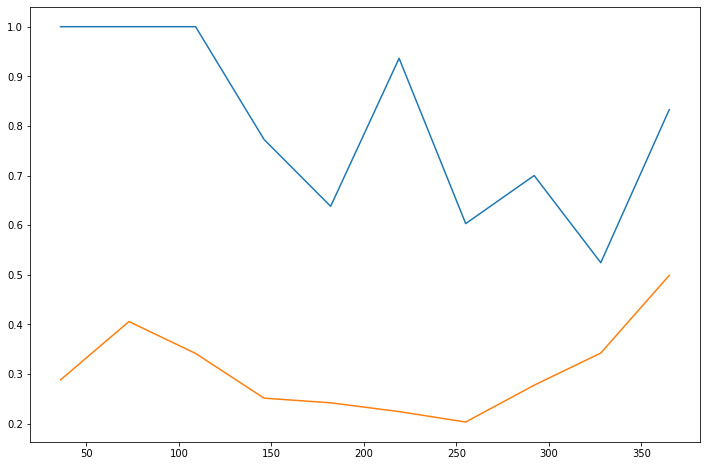

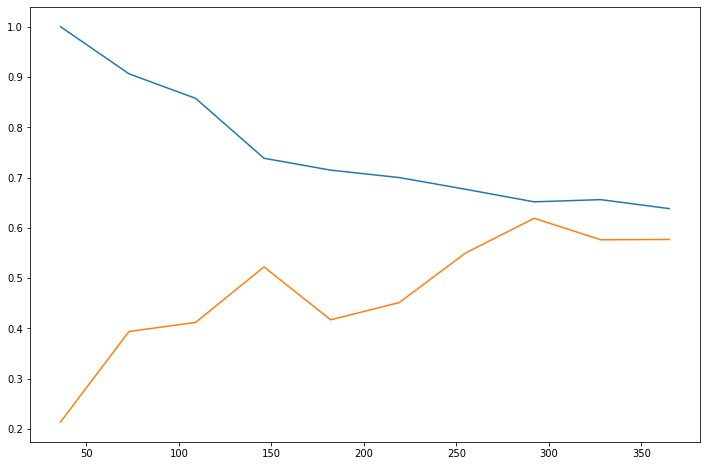

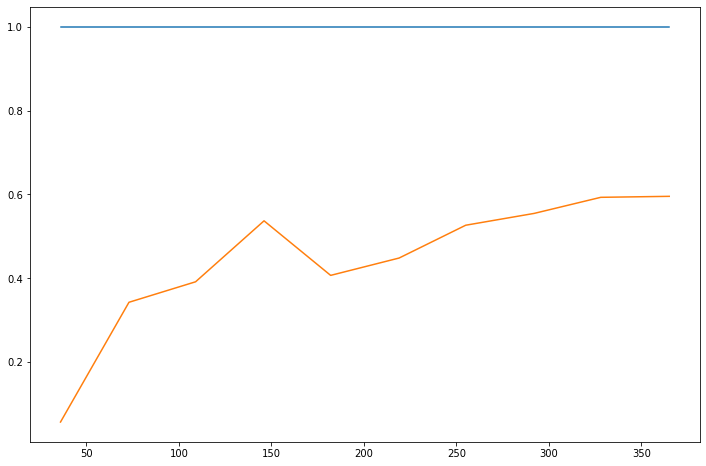

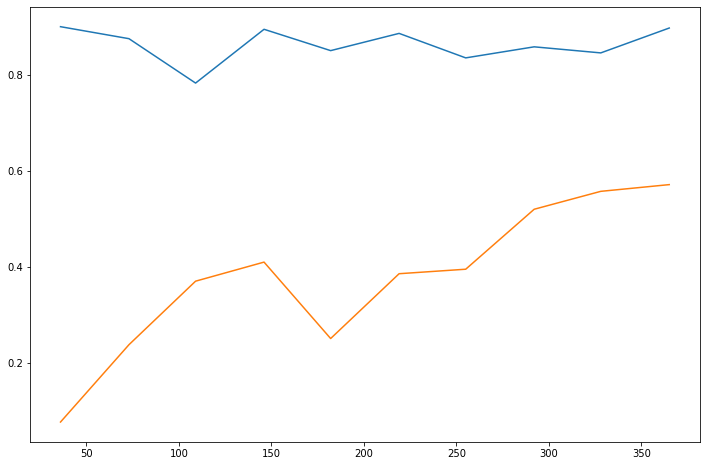

In [5]:
#KNN
model_KNN = KNeighborsClassifier(
                algorithm='auto',
                metric= 'euclidean',
                n_neighbors=11,
                weights='distance'
)

KNN = make_pipeline(preprocessor, StandardScaler(), model_KNN)

#BOOSTING
model_Dec = DecisionTreeClassifier(
    random_state=0,
    min_samples_split=3,
    max_leaf_nodes=74,
    max_depth=6,
    criterion='gini'
)

model_Boosting = AdaBoostClassifier(
    random_state=0,
    base_estimator=model_Dec,
    n_estimators=20,
    learning_rate=4.0
)

preprocessor2 = make_pipeline(PolynomialFeatures(3, include_bias=False), SelectKBest(f_classif, k=45))
AdaBoos = make_pipeline(preprocessor2, model_Boosting)

#SVM
model_SVM = SVC(
    gamma=0.001,
    C = 1000
)

preprocessor3 = make_pipeline(preprocessor, StandardScaler())


SVM = make_pipeline(preprocessor3, model_SVM)


def get_stacking():
    # definir les models de bases
    level0 = list()
    level0.append(('AdaBoost', AdaBoos))
    level0.append(('KNN', KNN))
    level0.append(('SVM', SVM))
    # definir meta model
    level1 = LogisticRegression()
    # deifinir stacking model
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

nos_models ={
    "AdaBoost": AdaBoos,
    "SVM": SVM,
    "KNN": KNN,
    "stacking": get_stacking()
}

for name, model in nos_models.items():
    print(name)
    evaluation(model)

In [6]:
AdaBoos

Pipeline(memory=None,
         steps=[('pipeline',
                 Pipeline(memory=None,
                          steps=[('polynomialfeatures',
                                  PolynomialFeatures(degree=3,
                                                     include_bias=False,
                                                     interaction_only=False,
                                                     order='C')),
                                 ('selectkbest',
                                  SelectKBest(k=45,
                                              score_func=<function f_classif at 0x1a1c869b00>))],
                          verbose=False)),
                ('adaboostclassifier',
                 AdaBoostClassifier(algorithm='SAMME.R',
                                    base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                          class_weight=None,
                                                       

In [13]:
hyper_params = {'adaboostclassifier__learning_rate':[1,2,3,4,5],
                'adaboostclassifier__n_estimators':[35, 37,40, 43], 
                'pipeline__polynomialfeatures__degree':[2,3,4]
               }

In [14]:
grid = RandomizedSearchCV(AdaBoos, hyper_params, scoring='recall', cv=4,
                          n_iter=40)

grid.fit(X_train, y_train)

print(grid.best_params_)

{'pipeline__polynomialfeatures__degree': 3, 'adaboostclassifier__n_estimators': 40, 'adaboostclassifier__learning_rate': 4}


In [15]:
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90        95
           1       0.46      0.69      0.55        16

    accuracy                           0.84       111
   macro avg       0.70      0.78      0.73       111
weighted avg       0.87      0.84      0.85       111

